In [2]:
# Импортируем библиотеки

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import bootstrap
from scipy.stats import shapiro
from statsmodels.stats.multitest import multipletests

In [13]:
groups_df.columns

Index(['id', 'grp'], dtype='object')

In [3]:
# Сохраняем данные в датафреймы
# После проверки корректности выбираем нужный тип сепараторов при сохранении в checks_df и groups_df
active_studs_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-vtjurin-mcl96-caefd/final/active_studs.csv')
checks_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-vtjurin-mcl96-caefd/final/checks.csv', sep = ';')
group_add_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-vtjurin-mcl96-caefd/final/group_add.csv')
groups_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-vtjurin-mcl96-caefd/final/groups.csv', sep = ';')

In [15]:
checks_df

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [5]:
# Как я понимаю, кусок данных из экспериментов доехал позже, но он валиден. Объединяем в один датафрейм
groups_result_df = pd.concat([groups_df, group_add_df], ignore_index=True)

In [6]:
# Добавим информацию об оплатах участников эксперимента
# Для этого сначала приведем названия поля по которому будем объединять в единый нейминг
# Потом заджойним по id по inner (стоит по умолчанию)
checks_df = checks_df.rename(columns={'student_id': 'id'})
experiment_result_df = pd.merge(groups_result_df, checks_df, on='id')

In [7]:
groups_result_df

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


# Проведем небольшой EDA

In [37]:
experiment_result_df.head()

,id,grp,rev
0,1627,A,990.0
1,3185,B,690.0
2,25973,B,690.0
3,26280,B,690.0
4,100300,B,990.0


In [38]:
# Типы данных 1
experiment_result_df.dtypes

id       int64
grp     object
rev    float64
dtype: object

In [39]:
# Лучше преобраовать id в строку
experiment_result_df['id'] = experiment_result_df['id'].astype(str)

In [40]:
# Типы данных 2
experiment_result_df.dtypes

id      object
grp     object
rev    float64
dtype: object

##### Очень странный результат при валидации на то, что эксперементируемые заходили на момент проведения эксперимента. Я бы на этом этапе остановился и начал выяснять в чем проблема, возможно ошибка в данных. Или, например, пользователи были активны ДО эксперимента и проводили оплату, а сама транзакция зафиксирована ВО ВРЕМЯ эксперимента. Во всяком случае нужно отчистить датафрейм от подозрительных id-шников

In [41]:
# На всякий случай провалидируемся на то, что участники эксперимента заходили в момент проведения эксперимента
# Переименуем корректно поле в active_studs_df и приведем к одному типу данных с полем id в experiment_result_df

active_studs_df = active_studs_df.rename(columns={'student_id': 'id'})
active_studs_df['id'] = active_studs_df['id'].astype(str)

frod_ids = experiment_result_df[~experiment_result_df['id'].isin(active_studs_df['id'])]
frod_ids_cnt = frod_ids['id'].nunique()

frod_ids_cnt

149

In [42]:
experiment_result_df['id'].nunique()

541

In [43]:
# исключим id, которые не заходили на платформу и получим очищенный датафрейм
filtered_experiment_result_df = experiment_result_df[experiment_result_df['id'].isin(active_studs_df['id'])]

In [44]:
filtered_experiment_result_df['id'].nunique()

392

In [45]:
# Размер датафрейма
filtered_experiment_result_df.shape

(392, 3)

In [46]:
# Проверим на наличие пустых значений
filtered_experiment_result_df.isnull().sum()

id     0
grp    0
rev    0
dtype: int64

In [47]:
# Посмотрим сколько наблюдений в контрольной и эксперементальной группах
filtered_experiment_result_df.groupby('grp')['id'].count()

grp
A     78
B    314
Name: id, dtype: int64

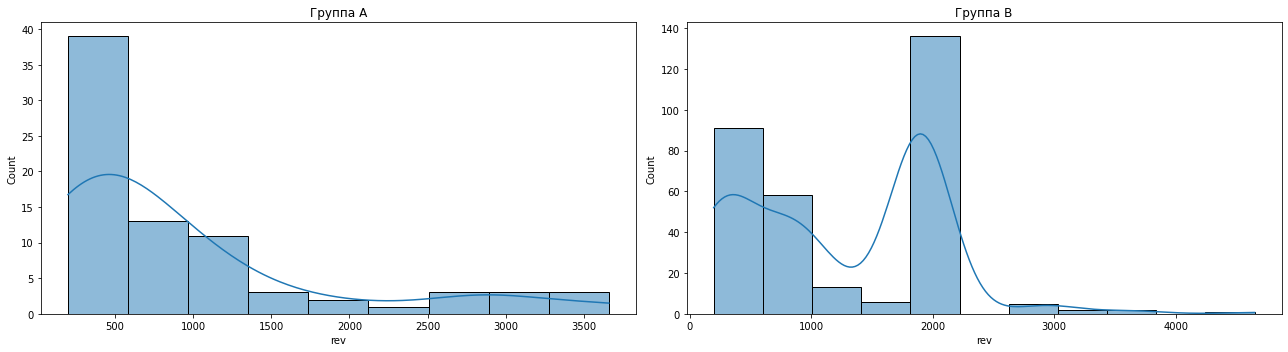

In [48]:
# Посмотрим на распределение rev по группам

df_experiment = filtered_experiment_result_df

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(df_experiment[df_experiment['grp'] == 'A']['rev'], ax=axes[0], kde=True)
axes[0].set_title('Группа A')

sns.histplot(df_experiment[df_experiment['grp'] == 'B']['rev'], ax=axes[1], kde=True)
axes[1].set_title('Группа B')

plt.tight_layout()
plt.show()

In [49]:
# Оеним сколько юзеров не платило
filtered_experiment_result_df[experiment_result_df["rev"] <= 0].count()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


id     0
grp    0
rev    0
dtype: int64

# Выберем метрики

Исходя из данных, которые у нас есть, логично использовать **ARPU в качестве основной метрики**, а т.к. у нас тяжелый правый хвост, то **в качестве дополнительной - Медиану по пользовательскому Revenue**

Было бы интересно посчитать конверсию в успешную оплату, но у нас нет таких данных. Также у нас нет данных о количестве оплат (по сути мы джойнили к юзерам rev, запись это уникальный юзер), так что средний чек тоже не посчитать

In [50]:
# Посчитаем ARPU и Медиану по группам

arpu_median_stats = (
    filtered_experiment_result_df
    .groupby('grp', as_index=False)
    .agg(ARPU = ('rev', 'mean'), Median_Rev = ('rev', 'median'))
)

arpu_median_stats.round(2)

,grp,ARPU,Median_Rev
0,A,933.59,585.0
1,B,1257.88,1140.0


# Выбор тестов

In [51]:
# Создадим массивы ARPU для групп
arpu_a = filtered_experiment_result_df.loc[filtered_experiment_result_df['grp']=='A', 'rev'].values
arpu_b = filtered_experiment_result_df.loc[filtered_experiment_result_df['grp']=='B', 'rev'].values

In [52]:
# Уже было видно раньше, что распределения не нормальны, 
# но на всякий случай проведем тест Шапиро-Уилка
for arr, label in [(arpu_a, 'A'), (arpu_b, 'B')]:
    W, p = shapiro(arr)
    print(f"{label}: W={W:.3f}, p={p:.3f}")

A: W=0.735, p=0.000
B: W=0.855, p=0.000


По тесту Шапиро-Уилка, а также исходя из форм распределения из гистограм rev по-группам, можно сказать что наше распределение сильно отклоняется от нормального. Обычно t-тесты, если говорить про ARPU (среднее), нуждаются либо в достаточно большой выборке (у нас в группе A всего 78 наблюдений), либо в приближенном к нормальному распределении. Также, в принципе, у нас разный размер выборок и разные формы распределений (т.е. Манна-Уитни и пермутационный тест для оценки медианы тоже отклоняется). Логарифирование данных для получения нормальных распределений потом трудновато интерпретировать.

В принципе нам подходит бутстрап, т.к. он не требует нормальности, работает с группами с разным кол-ом наблюдений и не требует предположений об одинаковой форме распределений. Так мы сможем оценить доверительные интервалы. Статистическую значимость будем смотреть по p-value после поправки Холма-Бонферрони, чтобы избежать множественных сравнений (2 бутстрапа на одних и тех же данных). Само p-value рассчитывать при помощи перестановочного теста

Соответственно гипотезы для перестановочного теста:
- H0: Распределение выручки в группах A и B идентично. Принадлежность к группе не влияет на значение среднего/медианы
- H1: Распределение выручки в группах A и B различается. Группа B имеет систематически более высокие значения среднего/медианы

Неявные гипотезы для бутстрапа:
- H0: Истинная разница средних (или медиан) между группами B и A равна нулю
- H1: Истинная разница средних (или медианы) между B и A не равна нулю

# Проведение тестов

In [53]:
# Permutation тест для p-value

# Напишем функцию, в аргументы которой будут передаваться 2 выборки, статистика и кол-во ресемплов
def permutation_p_value(data1, data2, statistic_func, n_resamples=10_000):
    observed_stat = statistic_func(data1, data2) # вычислим наблюдаемое значение статистики на исходных выборках
    combined = np.concatenate([data1, data2]) # для перемешивания меток объединим 2 выборки в 1 массив
    count = 0 # счетчик на число перестановок 
    
# Это основной цикл, по которому каждую итерацию перемешиваем метки и считаем статистику
    for _ in range(n_resamples):
        np.random.shuffle(combined) # случайно перемешиваем массив
        sample1 = combined[:len(data1)] # и опять его разделяем на 2 выборки 
        sample2 = combined[len(data1):] # первые len(data1) элементов - псевдоконтроль, а остальные - псевдолечение
        perm_stat = statistic_func(sample1, sample2) # считаем статистику перемешанного массива

        if abs(perm_stat) >= abs(observed_stat): # если по модулю перестановочная статистика не меньше исходной, то считаем это экстремальным случаем
            count += 1

    return count / n_resamples # p-value - по сути доля экстремальных перестановок от общего числа

In [54]:
# Бутстрап для ARPU

# Функция статистики для бутстрапа, она вернет разницу по ARPU между группами
# в аргументы передаем массивы выручке по группам, а также ось по которой считаем ARPU
# ось нужна, т.к. ниже при бутстрапировании будет vectorized=True, a и b имеют форму (n_resamples, sample_size), 
# здесь мы по сути берем среднее по каждому ресемплу
def stat_mean(a, b, axis=0):
    return np.mean(b, axis=axis) - np.mean(a, axis=axis)  # считаем np.mean(b) и np.mean(a) по указанной оси и возвращаем их разность

# Сам запуск бутстрапа для оценки CI
res_mean = bootstrap(
    data=(arpu_a, arpu_b),   # кортеж из массивов ARPU групп
    statistic=stat_mean,     # функция, вычисляющая интересующую нас статистику,функцию написали выше
    paired=False,            # выборки не попарные (разные пользователи в группах)
    vectorized=True,         # включаем «векторизованную» обработку ресемплов
    confidence_level=0.95,   # уровень доверия
    n_resamples=10_000,      # кол-во ресемплов, 10_000 == 10000, просто в первой форме можно записывать для наглядности
    method='percentile'      # берем 2.5 и 97.5 перцентили
)

# Считаем наблюдаемую разницу средних на исходных данных без ресемплирования
mean_diff_value = stat_mean(arpu_a, arpu_b)

print(f"Разница ARPU (B–A): {mean_diff_value:.2f}")

# из res_mean выводим границы CI
print(f"95% CI: [{res_mean.confidence_interval.low:.2f}, {res_mean.confidence_interval.high:.2f}]")

Разница ARPU (B–A): 324.29
95% CI: [93.72, 533.87]


In [55]:
# Permutation тест для p-value для ARPU
p_val_arpu = permutation_p_value(arpu_a, arpu_b, stat_mean, n_resamples=10_000)
print(f"p-value для ARPU: {p_val_arpu:.4f}")

p-value для ARPU: 0.0015


In [56]:
# Бутстрап для медиан
# Практически то же, что и для ARPU, здесь отличается только функция 

def stat_median(a, b, axis=0):
    return np.median(b, axis=axis) - np.median(a, axis=axis)

res_median = bootstrap(
    data=(arpu_a, arpu_b),
    statistic=stat_median,
    paired=False,
    vectorized=True,
    confidence_level=0.95,
    n_resamples=10_000,
    method='percentile'
)

median_diff_value = stat_median(arpu_a, arpu_b)
print(f"Разница медиан (B–A): {median_diff_value:.2f}")
print(f"95% CI для медианы: [{res_median.confidence_interval.low:.2f}, {res_median.confidence_interval.high:.2f}]")

Разница медиан (B–A): 555.00
95% CI для медианы: [330.00, 1320.00]


In [57]:
# Permutation тест для p-value для медиан
p_val_median = permutation_p_value(arpu_a, arpu_b, stat_median, n_resamples=10_000)
print(f"p-value для медианы: {p_val_median:.4f}")

p-value для медианы: 0.0404


In [58]:
# Поправка Холма-Бонферрони

p_values = [p_val_arpu, p_val_median] # собираем список исходных p-value

# multitest возвращает кортеж из 4 элементов: 
# 1) reject (булев массив, где True это отклонение H0)
# 2) pvals_corrected (массив скорректированных p-value)
# 3) два доп значения, которые не используем, но лучше их все же распаковать, чтобы ошибки не возникло
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

print(f"ARPU: {'Отклоняем H0' if reject[0] else 'Не отклоняем H0'}, p={pvals_corrected[0]:.4f}")
print(f"Медиана: {'Отклоняем H0' if reject[1] else 'Не отклоняем H0'}, p={pvals_corrected[1]:.4f}")

ARPU: Отклоняем H0, p=0.0030
Медиана: Отклоняем H0, p=0.0404


# Вывод

Новая механика оплаты демонстрирует статистически значимый и очень хороший экономически значимый рост пользовательской выручки.

Средняя выручка (ARPU) выросла на 324 RUB (рост на 34,7%), а медиана выручки выросла на 555 RUB (рост на 94,9%). Такая разница между средним и медианой обычно для правоскошенных распределений и означает, что фича особенно благоприятно повлияет в принципе как на "среднего" пользователя, так и на тех, кто тратит у нас много, обеспечивая стабильный и равномерный рост выручки на всей базе